In [1]:
using Random, Distributions, CairoMakie, StatsBase, Statistics, Colors, ColorSchemes, JLD2

hagoromo = ColorScheme([RGB(113/255,46/255,103/255),RGB(38/255,117/255,146/255),RGB(95/255,177/255,42/255),RGB(199/255,200/255,0/255),RGB(255/255,121/255,23/255),RGB(226/255,58/255,52/255)])

mlila=colorant"rgb(113,46,103)";
mblue=colorant"rgb(38,117,146)";
mgreen=colorant"rgb(95,177,42)";
myellow=colorant"rgb(199,200,0)";
morange=colorant"rgb(255,121,23)";
mred=colorant"rgb(226,58,52)";

In [9]:
using TickTock

In [2]:
function generate_sets(N::Int, M::Int)
    
    sets = []
    for i in 1:M
        qmax=rand(1:N)
        push!(sets, Set(randperm(N)[1:qmax]))
    end

    return sets
end

generate_sets (generic function with 1 method)

We generate a set of *M* sets with *N* nodes. Node *i* belongs to edge *j* with probability *p*.

In [3]:
function generate_hyperedges(N::Int,M::Int, p::Float64)
    d = Binomial(N,p)
    qvec= rand(d,M)
    sets = []
    for i in 1:M
        qset= Set(sample(1:N,qvec[i],replace=false))
        push!(sets, qset)
    end
    return sets
end

generate_hyperedges (generic function with 1 method)

In [71]:
function node_degree(node,sets)
    nsets = length(sets)
    ndeg = 0
    for i in 1:nsets
        if node in sets[i]
            ndeg +=1
        end
    end
    return ndeg
end

function degree_dist(nodes,sets)
    nnodes = length(nodes)
    xdeg=1:nnodes
    nrdeg= zeros(Int64,nnodes)
    for i in 1:nnodes
        nrdeg[i] = node_degree(i,sets)
    end
    return xdeg, nrdeg
end


function node_incident(nodes,sets)
    nnodes = length(nodes)
    nsets = length(sets)
    xdeg=1:nnodes
    nrdeg= zeros(Int64,nnodes,2)
    inclist=[]
    for i in 1:nnodes
        push!(inclist,[]) 
        for j in 1:nsets 
            qneighbours = 0
            if i in sets[j]
                nrdeg[i,1]+=1
                #qneighbours = []
                for k in sets[j]
                    if k!=i
                        push!(inclist[i],k)
                        nrdeg[i,2] +=1
                    end
                end
            end
        end
    end
    return xdeg, nrdeg, inclist
end

node_incident (generic function with 1 method)

In [48]:
function animal_counter(nodes,sets)
    nnodes = length(nodes)
    xdeg, nrdeg,inclist = node_incident(nodes,sets)
    animal = zeros(Int64,7)
    for i in 1:nnodes
        if nrdeg[i,1]==1 && nrdeg[i,2]==5
            animal[7] += 1
        end
        if nrdeg[i,1]==2 && nrdeg[i,2]==5
            animal[6] += 1
        end
        if nrdeg[i,1]==2 && nrdeg[i,2]==5
            animal[5] += 1
        end
        if nrdeg[i,1]==3 && nrdeg[i,2]==5
            animal[4] += 1
        end
        if nrdeg[i,1]==3 && nrdeg[i,2]==5
            animal[3] += 1
        end
        if nrdeg[i,1]==4 && nrdeg[i,2]==5
            animal[2] += 1
        end
        if nrdeg[i,1]==5 && nrdeg[i,2]==5
            animal[1] += 1
        end
    end
    return animal
end

function check_sets(q,sets)
    s=[]
    for ex in sets
        if q in ex
            push!(s,length(ex))    
        end
    end
    return s
end

function animal_counterN(nodes,sets)
    nnodes = length(nodes)
    xdeg, nrdeg, inclist = node_incident(nodes,sets)
    animal = zeros(Int64,7)
    for i in 1:nnodes
        if nrdeg[i,1]==1 && nrdeg[i,2]==5
            animal[7] += 1
        end
        if nrdeg[i,1]==2 && nrdeg[i,2]==5
            s = check_sets(i,sets)
            #println("s:",s)
            if maximum(s)==5 && minimum(s)>1
                animal[6] += 1
            elseif maximum(s)==4 && minimum(s)>1
                  animal[5] += 1  
            end
        end
       
        if nrdeg[i,1]==3 && nrdeg[i,2]==5
            s = check_sets(i,sets)
            #println("s:",s)
            if maximum(s)==4 && minimum(s)>1
                animal[4] += 1
            elseif maximum(s)==3 && minimum(s)>1
                  animal[3] += 1  
            end
        end
        #if nrdeg[i,1]==3 && nrdeg[i,2]==5
         #   animal[3] += 1
        #end
        if nrdeg[i,1]==4 && nrdeg[i,2]==5
            animal[2] += 1
        end
        if nrdeg[i,1]==5 && nrdeg[i,2]==5
            animal[1] += 1
        end
    end
    return animal
end

function edge_cap_count(sets)
    edgesizes = length.(sets)
    cap = zeros(Float64,6)
    for i in edgesizes
        if 1<i<7
            cap[i-1] +=1
        end
    end
    return cap
end

function deg_count(nrdeg)
    nodes = length(nrdeg)
    fdeg = zeros(Float64,5)
    for i in nrdeg
        if 0<i<6
            fdeg[i] +=1.0
        end
    end
    return fdeg
end

function animal_counterFrac(nodes,sets,inclist)
    nnodes = length(nodes)
    medges = length(sets)
    
    xdeg, nrdeg, inclist = node_incident(nodes,sets)
    # degcount is the number of nodes with degree 1,..,5
    # caps contains the number of hyperedges of size 2,...,6
    degcount = deg_count(nrdeg)
    caps = edge_cap_count(sets)
    degcount = degcount./nnodes
    caps = caps./medges
    println("Cap:   ",caps)
    println("Deg:   ", degcount)
    animal = zeros(Int64,7)
    animalF = zeros(Float64,7)
    for i in 1:nnodes
        if nrdeg[i,1]==1 && nrdeg[i,2]==5
            animalmult = 1.0
            for j in 1:inclist[i]
                if nrdeg[j,1]==1 && nrdeg[i,2]==5
                    animalmult+=1.0
                end
            end
            animal[7] += 1
            animalF[7] += degcount[1]*caps[5]/animalmult
        end
        if nrdeg[i,1]==2 && nrdeg[i,2]==5
            s = check_sets(i,sets)
            #println("s:",s)
            if maximum(s)==5 && minimum(s)>1
                animal[6] += 1
                animalF[6]+= degcount[2]*caps[4]*caps[1]
            elseif maximum(s)==4 && minimum(s)>1
                animal[5] += 1  
                animalF[5]+= nrdeg[2]*caps[3]*caps[2]
            end
        end
       
        if nrdeg[i,1]==3 && nrdeg[i,2]==5
            s = check_sets(i,sets)
            #println("s:",s)
            if maximum(s)==4 && minimum(s)>1
                animal[4] += 1
                animalF[4]+= degcount[3]*caps[3]*caps[1]^2
            elseif maximum(s)==3 && minimum(s)>1
                animal[3] += 1  
                animalF[3]+= degcount[3]*caps[1]*caps[2]^2
            end
        end
        #if nrdeg[i,1]==3 && nrdeg[i,2]==5
         #   animal[3] += 1
        #end
        if nrdeg[i,1]==4 && nrdeg[i,2]==5
            animal[2] += 1
            animalF[2]+= degcount[4]*caps[2]*caps[1]^3
        end
        if nrdeg[i,1]==5 && nrdeg[i,2]==5
            animal[1] += 1
            animalF[1]+= degcount[5]*caps[5]^3
        end
    end
    return animal, animalF
end

animal_counterFrac (generic function with 1 method)

In [6]:
function hypanimal(N,M,p,l)
    d1 = Binomial(N,p)  # edges
    d2 = Binomial(M,p)  # nodes 
    renorm1 = 1.0-cdf(d1,1)
    renorm2 = 1.0-cdf(d2,0)
    #println(renorm1)
    #println(renorm2)
    invmult = 1 # goes into multiplicity
    k = length(l)
    q=0
    prob = pdf(d2,k)/renorm2
    for li in l
        q+= (li-1)
        invmult *= factorial(li-1)
        #println("li  ", li, "    invmult ",invmult)
        prob *= (pdf(d1,li)/renorm1)
    end
    #println(prob)
    #println(invmult)
    prob *= (factorial(q)/invmult)
    #println(factorial(q)/invmult)
    #println(prob)
    return prob
end


hypanimal (generic function with 1 method)

In [149]:
function hypanimaltheory(N,M,p,l)
    d1 = Binomial(N,p)  # edges
    d2 = Binomial(M,p)  # nodes 
    invmult = 1 # goes into multiplicity
    k = length(l)
    q=0
    prob = pdf(d2,k)#/renorm2
    for li in l
        q+= (li-1)
        invmult *= factorial(li-1)
        prob *= pdf(d1,li)#/renorm1
    end
    prob *= (factorial(q)/invmult)
    return prob
end


hypanimaltheory (generic function with 1 method)

In [17]:
tick()
counts_over_p =[]#zeros(Int64,41,7)
pvals= 0.0005:0.0005:0.011
#pvals= [0.02,0.03]
pnr = 0
for pp in pvals
    println(pp)
    pnr+=1
    counts = zeros(Int64,7)
    for i in 1:1000
#        println("Start")
        hg1=generate_hyperedges(1000,10,pp);
#        println("Middle")
        g= animal_counterN(1:1000,hg1)
#        println("End")
        counts .+= g
    end
    push!(counts_over_p,counts) 
end

myd=counts_over_p;
mymat=zeros(Int64,7,22)

for i in 1:22
    for j in 1:7
        mymat[j,i] = myd[i][j]
    end
end
tock()

0.0005


[ Info:  started timer at: 2024-06-18T13:29:09.226


0.001
0.0015
0.002
0.0025
0.003
0.0035
0.004
0.0045
0.005
0.0055
0.006
0.0065
0.007
0.0075
0.008
0.0085
0.009
0.0095
0.01
0.0105
0.011


[ Info:         17.573724208s: 17 seconds, 573 milliseconds


In [18]:
tryval10 = counts_over_p

22-element Vector{Any}:
 [0, 0, 0, 0, 0, 0, 6]
 [0, 0, 0, 0, 1, 0, 30]
 [0, 0, 0, 0, 4, 3, 183]
 [0, 0, 0, 0, 19, 7, 564]
 [0, 0, 0, 0, 26, 19, 1737]
 [0, 0, 0, 0, 38, 24, 2866]
 [0, 0, 0, 0, 35, 12, 4362]
 [0, 0, 0, 0, 45, 14, 6070]
 [0, 0, 0, 0, 40, 22, 7583]
 [0, 0, 0, 0, 29, 13, 8137]
 [0, 0, 0, 0, 16, 7, 8915]
 [0, 0, 0, 0, 11, 3, 9099]
 [0, 0, 0, 0, 7, 2, 8886]
 [0, 0, 0, 0, 3, 6, 8288]
 [0, 0, 0, 0, 5, 0, 8025]
 [0, 0, 0, 0, 1, 1, 6726]
 [0, 0, 0, 0, 1, 0, 6193]
 [0, 0, 0, 0, 1, 0, 5128]
 [0, 0, 0, 0, 0, 0, 4590]
 [0, 0, 0, 0, 0, 0, 3257]
 [0, 0, 0, 0, 0, 0, 2826]
 [0, 0, 0, 0, 0, 0, 2037]

In [20]:
mymat10=zeros(Int64,7,22)
myd=tryval10
for i in 1:22
    for j in 1:7
        mymat10[j,i] = myd[i][j]
    end
end

mymat100=zeros(Int64,7,22)
myd=tryval100
for i in 1:22
    for j in 1:7
        mymat100[j,i] = myd[i][j]
    end
end

mymat1000=zeros(Int64,7,22)
myd=tryval1000
for i in 1:22
    for j in 1:7
        mymat1000[j,i] = myd[i][j]
    end
end

mymat2000=zeros(Int64,7,22)
myd=tryval2000
for i in 1:22
    for j in 1:7
        mymat2000[j,i] = myd[i][j]
    end
end

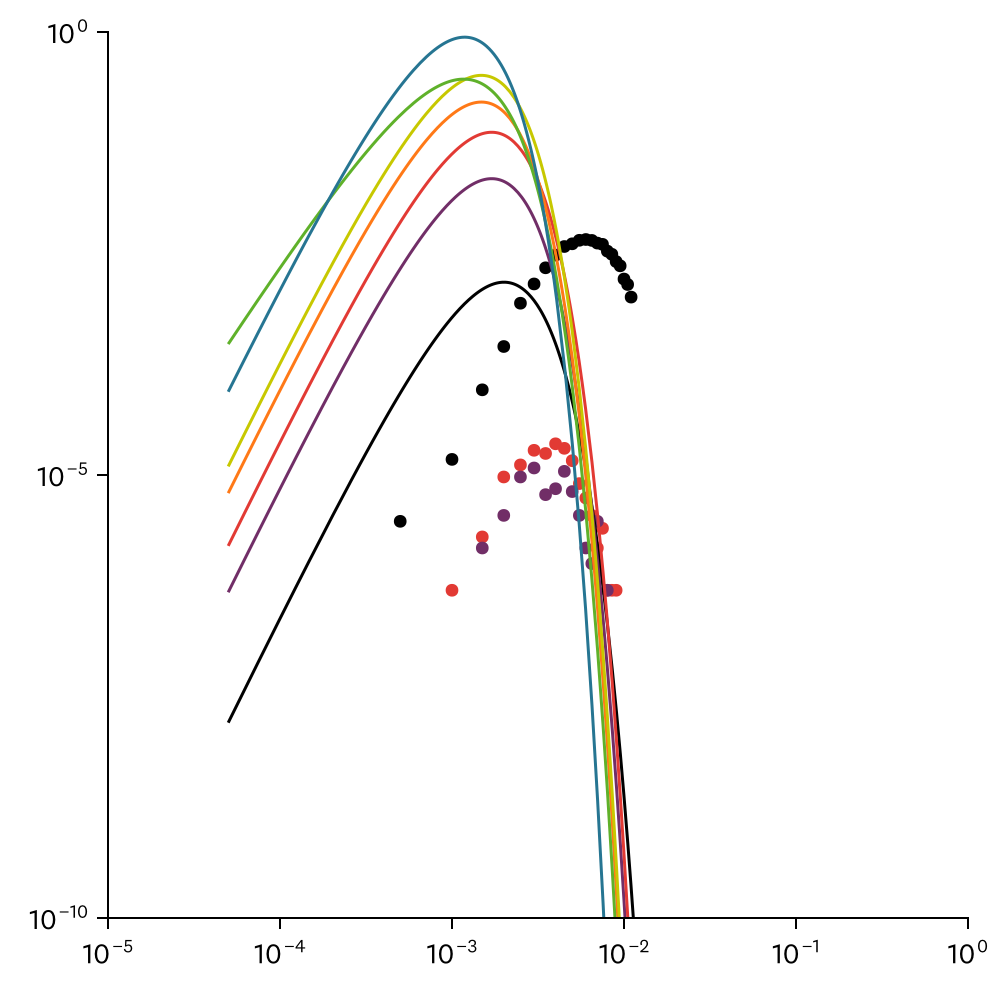

In [21]:
fig = Figure(size=(500,500),fonts = (;regular = "National 2 Regular", weird = "Blackchancery"))

ax1 = Axis(fig[1, 1], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,
        limits = ((10^-5,1), (10^-10,1)))
#ax2 = Axis(f[1, 1], yticklabelcolor = :red, yaxisposition = :right)
#hidespines!(ax2)
#hidexdecorations!(ax2)

scatter!(ax1, pvals, (0.0000000001.+mymat[1,1:22])./2000000, color = mblue);
scatter!(ax1, pvals, (0.0000000001.+mymat[2,1:22])./2000000, color = mgreen);
scatter!(ax1, pvals, (0.0000000001.+mymat[3,1:22])./2000000, color = myellow);
scatter!(ax1, pvals, (0.0000000001.+mymat[4,1:22])./2000000, color = morange);
scatter!(ax1, pvals, (0.0000000001.+mymat[5,1:22])./2000000, color = mred);
scatter!(ax1, pvals, (0.0000000001.+mymat[6,1:22])./2000000, color = mlila);
scatter!(ax1, pvals, (0.0000000001.+mymat[7,1:22])./2000000, color = :black);
lines!(ax1, 0.00005..0.015, x->hypanimal(1000,2000,x,[6]), color = :black);
lines!(ax1, 0.00005..0.015, x->hypanimal(1000,2000,x,[5,2]), color = mlila);
lines!(ax1, 0.00005..0.015, x->hypanimal(1000,2000,x,[4,3]), color = mred);
lines!(ax1, 0.00005..0.015, x->hypanimal(1000,2000,x,[4,2,2]), color = morange);
lines!(ax1, 0.00005..0.015, x->hypanimal(1000,2000,x,[3,3,2]), color = myellow);
lines!(ax1,  0.00005..0.015, x->hypanimal(1000,2000,x,[3,2,2]), color = mgreen);
lines!(ax1, 0.00005..0.015, x->hypanimal(1000,2000,x,[2,2,2,2,2]), color = mblue);

fig

In [120]:
tryval1000 = tryval100;

In [ ]:
@save "dat10N50Mpow8.jld2" tryval

In [ ]:
@load "dat10N50Mpow8.jld2" tryval

In [123]:
pvals= 0.0005:0.0005:0.011
hypan1000N10Mpow8= tryval

22-element Vector{Any}:
 [0, 0, 0, 0, 0, 0, 1]
 [0, 0, 0, 1, 0, 16, 28]
 [0, 0, 0, 11, 0, 101, 172]
 [0, 1, 0, 17, 0, 259, 591]
 [0, 0, 0, 24, 0, 412, 1293]
 [0, 0, 0, 21, 0, 568, 2325]
 [0, 0, 0, 13, 0, 541, 3201]
 [0, 0, 0, 12, 0, 515, 4341]
 [0, 0, 0, 5, 0, 408, 4873]
 [0, 0, 0, 0, 0, 284, 5387]
 ⋮
 [0, 0, 0, 0, 0, 51, 4485]
 [0, 0, 0, 0, 0, 20, 3891]
 [0, 0, 0, 0, 0, 17, 3345]
 [0, 0, 0, 0, 0, 2, 2760]
 [0, 0, 0, 0, 0, 3, 2192]
 [0, 0, 0, 0, 0, 0, 1747]
 [0, 0, 0, 0, 0, 0, 1342]
 [0, 0, 0, 0, 0, 0, 1066]
 [0, 0, 0, 0, 0, 2, 823]

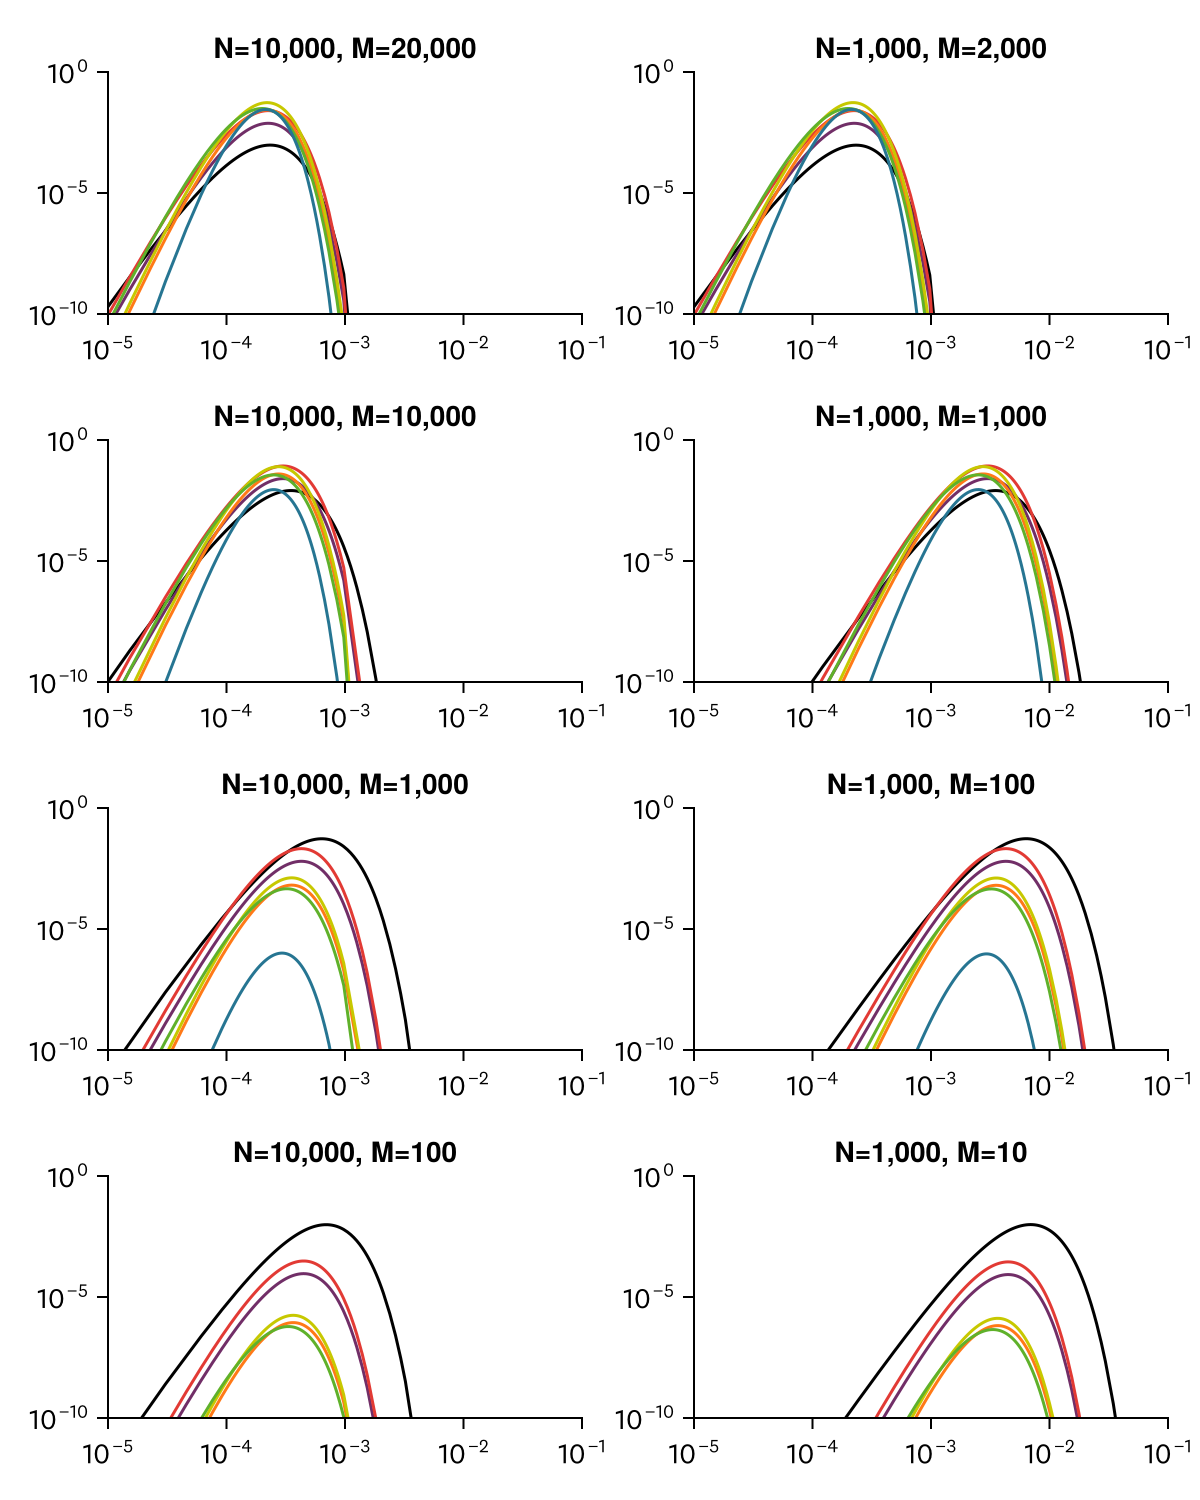

In [25]:
#FigureC = Figure(size=(1100,1500),fonts = (;regular = "National 2 Regular"))
FigureC = Figure(size=(600,750),fonts = (;regular = "National 2 Regular"))

    ax1a = Axis(FigureC[1, 1], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=10,000, M=20,000",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax2a = Axis(FigureC[1, 2], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=1,000, M=2,000",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax1 = Axis(FigureC[2, 1], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=10,000, M=10,000",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax2 = Axis(FigureC[2, 2], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=1,000, M=1,000",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax3 = Axis(FigureC[3, 1], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=10,000, M=1,000",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax4 = Axis(FigureC[3, 2], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=1,000, M=100",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax5 = Axis(FigureC[4, 1], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=10,000, M=100",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax6 = Axis(FigureC[4, 2], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=1,000, M=10",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())


lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(10000,20000,x,[6]), color = :black);
lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(10000,20000,x,[5,2]), color = mlila);
lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(10000,20000,x,[4,3]), color = mred);
lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(10000,20000,x,[4,2,2]), color = morange);
lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(10000,20000,x,[3,3,2]), color = myellow);
lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(10000,20000,x,[3,2,2]), color = mgreen);
lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(10000,20000,x,[2,2,2,2,2]), color = mblue);



lines!(ax2a, 0.00000005..0.15, x->hypanimaltheory(1000,2000,x*10,[6]), color = :black);
lines!(ax2a, 0.00000005..0.15, x->hypanimaltheory(1000,2000,x*10,[5,2]), color = mlila);
lines!(ax2a, 0.00000005..0.15, x->hypanimaltheory(1000,2000,x*10,[4,3]), color = mred);
lines!(ax2a, 0.00000005..0.15, x->hypanimaltheory(1000,2000,x*10,[4,2,2]), color = morange);
lines!(ax2a, 0.00000005..0.15, x->hypanimaltheory(1000,2000,x*10,[3,3,2]), color = myellow);
lines!(ax2a, 0.00000005..0.15, x->hypanimaltheory(1000,2000,x*10,[3,2,2]), color = mgreen);
lines!(ax2a, 0.00000005..0.15, x->hypanimaltheory(1000,2000,x*10,[2,2,2,2,2]), color = mblue);


lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(10000,10000,x,[6]), color = :black);
lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(10000,10000,x,[5,2]), color = mlila);
lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(10000,10000,x,[4,3]), color = mred);
lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(10000,10000,x,[4,2,2]), color = morange);
lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(10000,10000,x,[3,3,2]), color = myellow);
lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(10000,10000,x,[3,2,2]), color = mgreen);
lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(10000,10000,x,[2,2,2,2,2]), color = mblue);



lines!(ax2, 0.00000005..0.15, x->hypanimaltheory(1000,1000,x,[6]), color = :black);
lines!(ax2, 0.00000005..0.15, x->hypanimaltheory(1000,1000,x,[5,2]), color = mlila);
lines!(ax2, 0.00000005..0.15, x->hypanimaltheory(1000,1000,x,[4,3]), color = mred);
lines!(ax2, 0.00000005..0.15, x->hypanimaltheory(1000,1000,x,[4,2,2]), color = morange);
lines!(ax2, 0.00000005..0.15, x->hypanimaltheory(1000,1000,x,[3,3,2]), color = myellow);
lines!(ax2, 0.00000005..0.15, x->hypanimaltheory(1000,1000,x,[3,2,2]), color = mgreen);
lines!(ax2, 0.00000005..0.15, x->hypanimaltheory(1000,1000,x,[2,2,2,2,2]), color = mblue);

lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(10000,1000,x,[6]), color = :black);
lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(10000,1000,x,[5,2]), color = mlila);
lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(10000,1000,x,[4,3]), color = mred);
lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(10000,1000,x,[4,2,2]), color = morange);
lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(10000,1000,x,[3,3,2]), color = myellow);
lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(10000,1000,x,[3,2,2]), color = mgreen);
lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(10000,1000,x,[2,2,2,2,2]), color = mblue);



lines!(ax4, 0.00000005..0.15, x->hypanimaltheory(1000,100,x,[6]), color = :black);
lines!(ax4, 0.00000005..0.15, x->hypanimaltheory(1000,100,x,[5,2]), color = mlila);
lines!(ax4, 0.00000005..0.15, x->hypanimaltheory(1000,100,x,[4,3]), color = mred);
lines!(ax4, 0.00000005..0.15, x->hypanimaltheory(1000,100,x,[4,2,2]), color = morange);
lines!(ax4, 0.00000005..0.15, x->hypanimaltheory(1000,100,x,[3,3,2]), color = myellow);
lines!(ax4, 0.00000005..0.15, x->hypanimaltheory(1000,100,x,[3,2,2]), color = mgreen);
lines!(ax4, 0.00000005..0.15, x->hypanimaltheory(1000,100,x,[2,2,2,2,2]), color = mblue);

lines!(ax5, 0.00000005..0.15, x->hypanimaltheory(10000,100,x,[6]), color = :black);
lines!(ax5, 0.00000005..0.15, x->hypanimaltheory(10000,100,x,[5,2]), color = mlila);
lines!(ax5, 0.00000005..0.15, x->hypanimaltheory(10000,100,x,[4,3]), color = mred);
lines!(ax5, 0.00000005..0.15, x->hypanimaltheory(10000,100,x,[4,2,2]), color = morange);
lines!(ax5, 0.00000005..0.15, x->hypanimaltheory(10000,100,x,[3,3,2]), color = myellow);
lines!(ax5, 0.00000005..0.15, x->hypanimaltheory(10000,100,x,[3,2,2]), color = mgreen);
lines!(ax5, 0.00000005..0.15, x->hypanimaltheory(10000,100,x,[2,2,2,2,2]), color = mblue);



lines!(ax6, 0.00000005..0.15, x->hypanimaltheory(1000,10,x,[6]), color = :black);
lines!(ax6, 0.00000005..0.15, x->hypanimaltheory(1000,10,x,[5,2]), color = mlila);
lines!(ax6, 0.00000005..0.15, x->hypanimaltheory(1000,10,x,[4,3]), color = mred);
lines!(ax6, 0.00000005..0.15, x->hypanimaltheory(1000,10,x,[4,2,2]), color = morange);
lines!(ax6, 0.00000005..0.15, x->hypanimaltheory(1000,10,x,[3,3,2]), color = myellow);
lines!(ax6, 0.00000005..0.15, x->hypanimaltheory(1000,10,x,[3,2,2]), color = mgreen);
lines!(ax6, 0.00000005..0.15, x->hypanimaltheory(1000,10,x,[2,2,2,2,2]), color = mblue);
#Label(FigureC[1,1],"N=10,000, M=10,000")
#Label(FigureC[1,2],"N=1,000, M=1,000")

FigureC

In [352]:
save("FigureC.pdf",FigureC,px_per_unit=2)

CairoMakie.Screen{PDF}


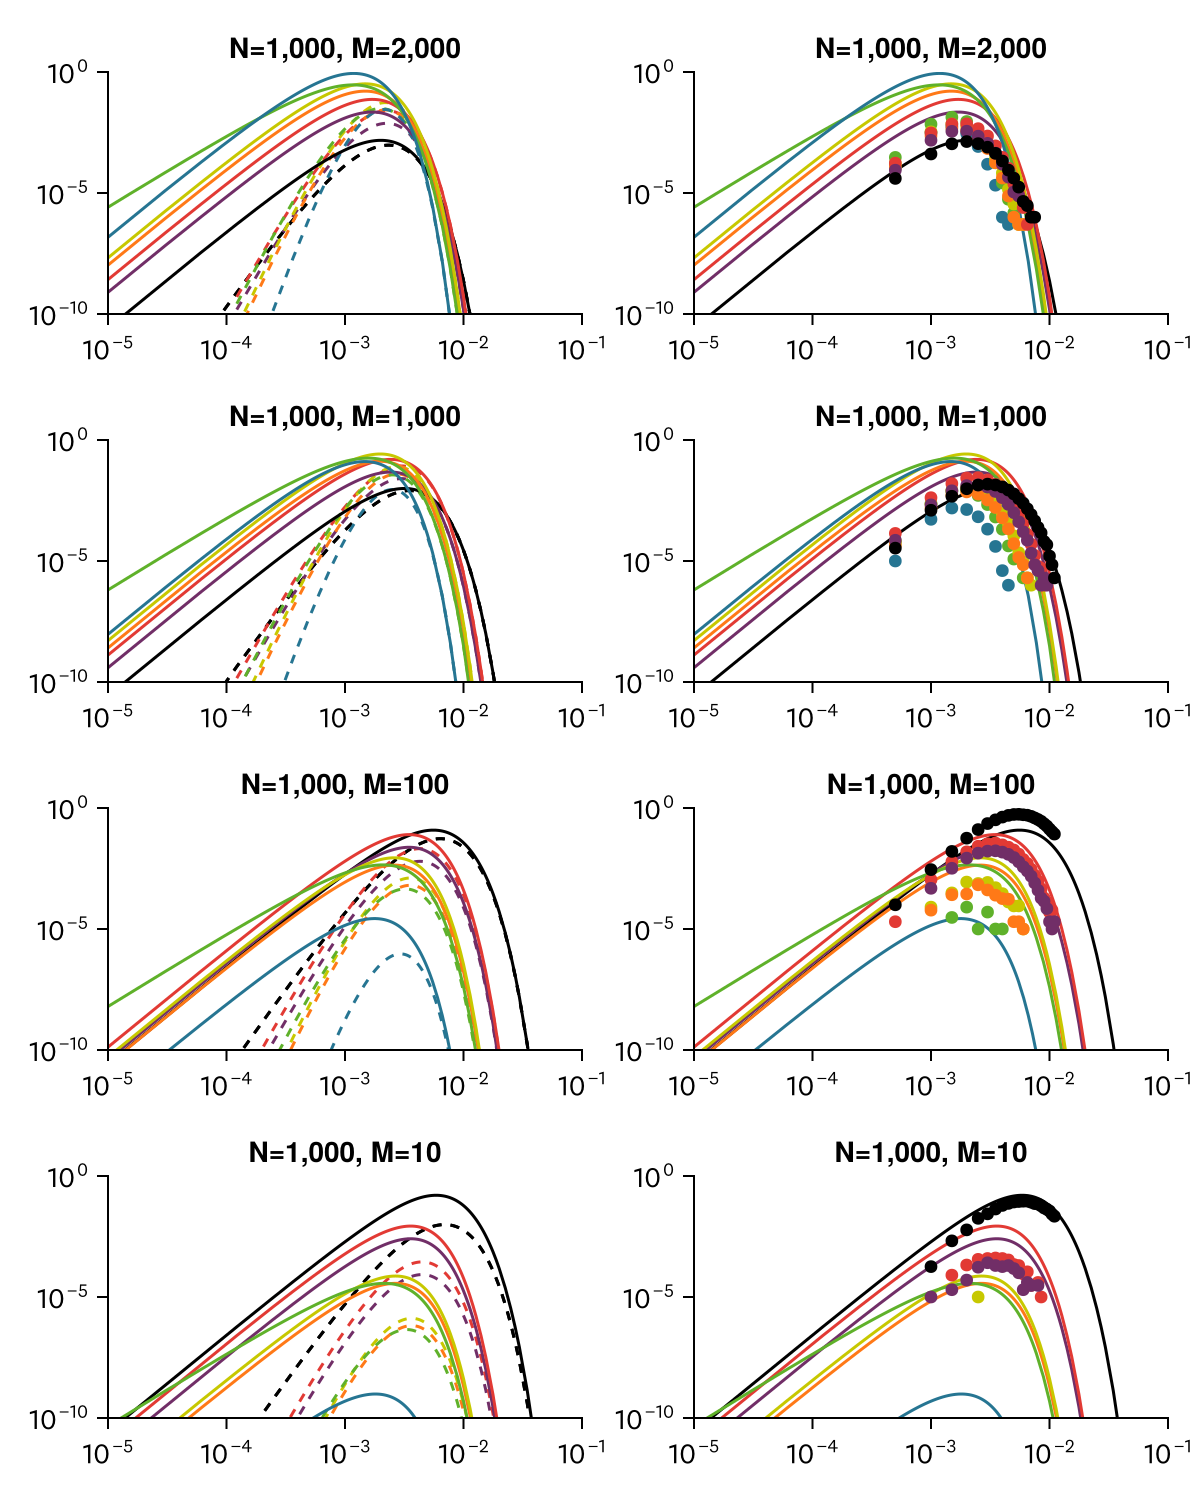

In [393]:
#FigureC = Figure(size=(1100,1500),fonts = (;regular = "National 2 Regular"))
FigureApp = Figure(size=(600,750),fonts = (;regular = "National 2 Regular"))

    ax1a = Axis(FigureApp[1, 1], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=1,000, M=2,000",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax2a = Axis(FigureApp[1, 2], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=1,000, M=2,000",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax1 = Axis(FigureApp[2, 1], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=1,000, M=1,000",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax2 = Axis(FigureApp[2, 2], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=1,000, M=1,000",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax3 = Axis(FigureApp[3, 1], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=1,000, M=100",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax4 = Axis(FigureApp[3, 2], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=1,000, M=100",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax5 = Axis(FigureApp[4, 1], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=1,000, M=10",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())

ax6 = Axis(FigureApp[4, 2], xscale=log10,yscale =log10, xtrimspine=(true,false),
        ytrimspine = (true, false),
        topspinevisible = false,
        rightspinevisible = false,
        xgridvisible = false,
        ygridvisible = false,title="N=1,000, M=10",
        limits = ((10^-5,0.1), (10^-10,1)),
        alignmode=Outside())


lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(1000,2000,x,[6]), linestyle=:dash, color = :black);
lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(1000,2000,x,[6]), linestyle=:dash, color = :black);
lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(1000,2000,x,[5,2]), linestyle=:dash, color = mlila);
lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(1000,2000,x,[4,3]), linestyle=:dash, color = mred);
lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(1000,2000,x,[4,2,2]),linestyle=:dash,  color = morange);
lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(1000,2000,x,[3,3,2]), linestyle=:dash, color = myellow);
lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(1000,2000,x,[3,2,2]), linestyle=:dash, color = mgreen);
lines!(ax1a, 0.000000005..0.15, x->hypanimaltheory(1000,2000,x,[2,2,2,2,2]), linestyle=:dash, color = mblue);
lines!(ax1a, 0.000000005..0.15, x->hypanimal(1000,2000,x,[6]),  color = :black);
lines!(ax1a, 0.000000005..0.15, x->hypanimal(1000,2000,x,[5,2]),  color = mlila);
lines!(ax1a, 0.000000005..0.15, x->hypanimal(1000,2000,x,[4,3]),  color = mred);
lines!(ax1a, 0.000000005..0.15, x->hypanimal(1000,2000,x,[4,2,2]),  color = morange);
lines!(ax1a, 0.000000005..0.15, x->hypanimal(1000,2000,x,[3,3,2]),  color = myellow);
lines!(ax1a, 0.000000005..0.15, x->hypanimal(1000,2000,x,[3,2,2]),  color = mgreen);
lines!(ax1a, 0.000000005..0.15, x->hypanimal(1000,2000,x,[2,2,2,2,2]),  color = mblue);



lines!(ax2a, 0.00000005..0.15, x->hypanimal(1000,2000,x,[6]), color = :black);
lines!(ax2a, 0.00000005..0.15, x->hypanimal(1000,2000,x,[5,2]), color = mlila);
lines!(ax2a, 0.00000005..0.15, x->hypanimal(1000,2000,x,[4,3]), color = mred);
lines!(ax2a, 0.00000005..0.15, x->hypanimal(1000,2000,x,[4,2,2]), color = morange);
lines!(ax2a, 0.00000005..0.15, x->hypanimal(1000,2000,x,[3,3,2]), color = myellow);
lines!(ax2a, 0.00000005..0.15, x->hypanimal(1000,2000,x,[3,2,2]), color = mgreen);
lines!(ax2a, 0.00000005..0.15, x->hypanimal(1000,2000,x,[2,2,2,2,2]), color = mblue);
scatter!(ax2a, pvals, (0.0000000001.+mymat2000[1,1:22])./2000000.0, color = mblue);
scatter!(ax2a, pvals, (0.0000000001.+mymat2000[2,1:22])./2000000, color = mgreen);
scatter!(ax2a, pvals, (0.0000000001.+mymat2000[3,1:22])./2000000, color = myellow);
scatter!(ax2a, pvals, (0.0000000001.+mymat2000[4,1:22])./2000000, color = morange);
scatter!(ax2a, pvals, (0.0000000001.+mymat2000[5,1:22])./2000000, color = mred);
scatter!(ax2a, pvals, (0.0000000001.+mymat2000[6,1:22])./2000000, color = mlila);
scatter!(ax2a, pvals, (0.0000000001.+mymat2000[7,1:22])./2000000, color = :black);

lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(1000,1000,x,[6]), linestyle=:dash, color = :black);
lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(1000,1000,x,[6]), linestyle=:dash, color = :black);
lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(1000,1000,x,[5,2]), linestyle=:dash, color = mlila);
lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(1000,1000,x,[4,3]), linestyle=:dash, color = mred);
lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(1000,1000,x,[4,2,2]),linestyle=:dash,  color = morange);
lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(1000,1000,x,[3,3,2]), linestyle=:dash, color = myellow);
lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(1000,1000,x,[3,2,2]), linestyle=:dash, color = mgreen);
lines!(ax1, 0.000000005..0.15, x->hypanimaltheory(1000,1000,x,[2,2,2,2,2]), linestyle=:dash, color = mblue);
lines!(ax1, 0.000000005..0.15, x->hypanimal(1000,1000,x,[6]),  color = :black);
lines!(ax1, 0.000000005..0.15, x->hypanimal(1000,1000,x,[5,2]),  color = mlila);
lines!(ax1, 0.000000005..0.15, x->hypanimal(1000,1000,x,[4,3]),  color = mred);
lines!(ax1, 0.000000005..0.15, x->hypanimal(1000,1000,x,[4,2,2]),  color = morange);
lines!(ax1, 0.000000005..0.15, x->hypanimal(1000,1000,x,[3,3,2]),  color = myellow);
lines!(ax1, 0.000000005..0.15, x->hypanimal(1000,1000,x,[3,2,2]),  color = mgreen);
lines!(ax1, 0.000000005..0.15, x->hypanimal(1000,1000,x,[2,2,2,2,2]),  color = mblue);


lines!(ax2, 0.00000005..0.15, x->hypanimal(1000,1000,x,[6]), color = :black);
lines!(ax2, 0.00000005..0.15, x->hypanimal(1000,1000,x,[5,2]), color = mlila);
lines!(ax2, 0.00000005..0.15, x->hypanimal(1000,1000,x,[4,3]), color = mred);
lines!(ax2, 0.00000005..0.15, x->hypanimal(1000,1000,x,[4,2,2]), color = morange);
lines!(ax2, 0.00000005..0.15, x->hypanimal(1000,1000,x,[3,3,2]), color = myellow);
lines!(ax2, 0.00000005..0.15, x->hypanimal(1000,1000,x,[3,2,2]), color = mgreen);
lines!(ax2, 0.00000005..0.15, x->hypanimal(1000,1000,x,[2,2,2,2,2]), color = mblue);
scatter!(ax2, pvals, (0.0000000001.+mymat1000[1,1:22])./1000000.0, color = mblue);
scatter!(ax2, pvals, (0.0000000001.+mymat1000[2,1:22])./1000000, color = mgreen);
scatter!(ax2, pvals, (0.0000000001.+mymat1000[3,1:22])./1000000, color = myellow);
scatter!(ax2, pvals, (0.0000000001.+mymat1000[4,1:22])./1000000, color = morange);
scatter!(ax2, pvals, (0.0000000001.+mymat1000[5,1:22])./1000000, color = mred);
scatter!(ax2, pvals, (0.0000000001.+mymat1000[6,1:22])./1000000, color = mlila);
scatter!(ax2, pvals, (0.0000000001.+mymat1000[7,1:22])./1000000, color = :black);

lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(1000,100,x,[6]), linestyle=:dash, color = :black);
lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(1000,100,x,[6]), linestyle=:dash, color = :black);
lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(1000,100,x,[5,2]), linestyle=:dash, color = mlila);
lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(1000,100,x,[4,3]), linestyle=:dash, color = mred);
lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(1000,100,x,[4,2,2]),linestyle=:dash,  color = morange);
lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(1000,100,x,[3,3,2]), linestyle=:dash, color = myellow);
lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(1000,100,x,[3,2,2]), linestyle=:dash, color = mgreen);
lines!(ax3, 0.000000005..0.15, x->hypanimaltheory(1000,100,x,[2,2,2,2,2]), linestyle=:dash, color = mblue);
lines!(ax3, 0.000000005..0.15, x->hypanimal(1000,100,x,[6]),  color = :black);
lines!(ax3, 0.000000005..0.15, x->hypanimal(1000,100,x,[5,2]),  color = mlila);
lines!(ax3, 0.000000005..0.15, x->hypanimal(1000,100,x,[4,3]),  color = mred);
lines!(ax3, 0.000000005..0.15, x->hypanimal(1000,100,x,[4,2,2]),  color = morange);
lines!(ax3, 0.000000005..0.15, x->hypanimal(1000,100,x,[3,3,2]),  color = myellow);
lines!(ax3, 0.000000005..0.15, x->hypanimal(1000,100,x,[3,2,2]),  color = mgreen);
lines!(ax3, 0.000000005..0.15, x->hypanimal(1000,100,x,[2,2,2,2,2]),  color = mblue);



lines!(ax4, 0.00000005..0.15, x->hypanimal(1000,100,x,[6]), color = :black);
lines!(ax4, 0.00000005..0.15, x->hypanimal(1000,100,x,[5,2]), color = mlila);
lines!(ax4, 0.00000005..0.15, x->hypanimal(1000,100,x,[4,3]), color = mred);
lines!(ax4, 0.00000005..0.15, x->hypanimal(1000,100,x,[4,2,2]), color = morange);
lines!(ax4, 0.00000005..0.15, x->hypanimal(1000,100,x,[3,3,2]), color = myellow);
lines!(ax4, 0.00000005..0.15, x->hypanimal(1000,100,x,[3,2,2]), color = mgreen);
lines!(ax4, 0.00000005..0.15, x->hypanimal(1000,100,x,[2,2,2,2,2]), color = mblue);
scatter!(ax4, pvals, (0.0000000001.+mymat100[1,1:22])./100000.0, color = mblue);
scatter!(ax4, pvals, (0.0000000001.+mymat100[2,1:22])./100000, color = mgreen);
scatter!(ax4, pvals, (0.0000000001.+mymat100[3,1:22])./100000, color = myellow);
scatter!(ax4, pvals, (0.0000000001.+mymat100[4,1:22])./100000, color = morange);
scatter!(ax4, pvals, (0.0000000001.+mymat100[5,1:22])./100000, color = mred);
scatter!(ax4, pvals, (0.0000000001.+mymat100[6,1:22])./100000, color = mlila);
scatter!(ax4, pvals, (0.0000000001.+mymat100[7,1:22])./100000, color = :black);

lines!(ax5, 0.000000005..0.15, x->hypanimaltheory(1000,10,x,[6]), linestyle=:dash, color = :black);
lines!(ax5, 0.000000005..0.15, x->hypanimaltheory(1000,10,x,[6]), linestyle=:dash, color = :black);
lines!(ax5, 0.000000005..0.15, x->hypanimaltheory(1000,10,x,[5,2]), linestyle=:dash, color = mlila);
lines!(ax5, 0.000000005..0.15, x->hypanimaltheory(1000,10,x,[4,3]), linestyle=:dash, color = mred);
lines!(ax5, 0.000000005..0.15, x->hypanimaltheory(1000,10,x,[4,2,2]),linestyle=:dash,  color = morange);
lines!(ax5, 0.000000005..0.15, x->hypanimaltheory(1000,10,x,[3,3,2]), linestyle=:dash, color = myellow);
lines!(ax5, 0.000000005..0.15, x->hypanimaltheory(1000,10,x,[3,2,2]), linestyle=:dash, color = mgreen);
lines!(ax5, 0.000000005..0.15, x->hypanimaltheory(1000,10,x,[2,2,2,2,2]), linestyle=:dash, color = mblue);
lines!(ax5, 0.000000005..0.15, x->hypanimal(1000,10,x,[6]),  color = :black);
lines!(ax5, 0.000000005..0.15, x->hypanimal(1000,10,x,[5,2]),  color = mlila);
lines!(ax5, 0.000000005..0.15, x->hypanimal(1000,10,x,[4,3]),  color = mred);
lines!(ax5, 0.000000005..0.15, x->hypanimal(1000,10,x,[4,2,2]),  color = morange);
lines!(ax5, 0.000000005..0.15, x->hypanimal(1000,10,x,[3,3,2]),  color = myellow);
lines!(ax5, 0.000000005..0.15, x->hypanimal(1000,10,x,[3,2,2]),  color = mgreen);
lines!(ax5, 0.000000005..0.15, x->hypanimal(1000,10,x,[2,2,2,2,2]),  color = mblue);


lines!(ax6, 0.00000005..0.15, x->hypanimal(1000,10,x,[6]), color = :black);
lines!(ax6, 0.00000005..0.15, x->hypanimal(1000,10,x,[5,2]), color = mlila);
lines!(ax6, 0.00000005..0.15, x->hypanimal(1000,10,x,[4,3]), color = mred);
lines!(ax6, 0.00000005..0.15, x->hypanimal(1000,10,x,[4,2,2]), color = morange);
lines!(ax6, 0.00000005..0.15, x->hypanimal(1000,10,x,[3,3,2]), color = myellow);
lines!(ax6, 0.00000005..0.15, x->hypanimal(1000,10,x,[3,2,2]), color = mgreen);
lines!(ax6, 0.00000005..0.15, x->hypanimal(1000,10,x,[2,2,2,2,2]), color = mblue);
scatter!(ax6, pvals, (0.0000000001.+mymat10[1,1:22])./100000.0, color = mblue);
scatter!(ax6, pvals, (0.0000000001.+mymat10[2,1:22])./100000, color = mgreen);
scatter!(ax6, pvals, (0.0000000001.+mymat10[3,1:22])./100000, color = myellow);
scatter!(ax6, pvals, (0.0000000001.+mymat10[4,1:22])./100000, color = morange);
scatter!(ax6, pvals, (0.0000000001.+mymat10[5,1:22])./100000, color = mred);
scatter!(ax6, pvals, (0.0000000001.+mymat10[6,1:22])./100000, color = mlila);
scatter!(ax6, pvals, (0.0000000001.+mymat10[7,1:22])./100000, color = :black);

#Label(FigureC[1,1],"N=10,000, M=10,000")
#Label(FigureC[1,2],"N=1,000, M=1,000")

FigureApp

In [394]:
save("FigureApp.pdf",FigureApp,px_per_unit=2)

CairoMakie.Screen{PDF}


In [117]:
function animal_counterFrac(nodes,sets)
    nnodes = length(nodes)
    medges = length(sets)
    
    xdeg, nrdeg, inclist = node_incident(nodes,sets)
    # degcount is the number of nodes with degree 1,..,5
    # caps contains the number of hyperedges of size 2,...,6
    degcount = deg_count(nrdeg)
    caps = edge_cap_count(sets)
    degcount = degcount./nnodes
    caps = caps./medges
#    println(nrdeg)
    if caps[5]>0.2
        println("Cap:   ",caps[5])
    end
#    println("Deg:   ", degcount)
    animal = zeros(Int64,7)
    animalF = zeros(Float64,7)
    for i in 1:nnodes
        if nrdeg[i,1]==1 && nrdeg[i,2]==5
            animalmult = 1.0
            for j in inclist[i]
                if nrdeg[j,1]==1 && nrdeg[j,2]==5
                    animalmult+=1.0
                    #println("Mult: ",animalmult)
                end
            end
            animalnumber = max(1.0,animalmult)
            animal[7] += 1
            animalF[7] += degcount[1]*caps[5]/animalnumber
        end
        if nrdeg[i,1]==2 && nrdeg[i,2]==5
            s = check_sets(i,sets)
            #println("s:",s)
            if maximum(s)==5 && minimum(s)>1
                animal[6] += 1
                animalF[6]+= degcount[2]*caps[4]*caps[1]
            elseif maximum(s)==4 && minimum(s)>1
                animal[5] += 1  
                animalF[5]+= degcount[2]*caps[3]*caps[2]
            end
        end
       
        if nrdeg[i,1]==3 && nrdeg[i,2]==5
            s = check_sets(i,sets)
            #println("s:",s)
            if maximum(s)==4 && minimum(s)>1
                animal[4] += 1
                animalF[4]+= degcount[3]*caps[3]*caps[1]^2
            elseif maximum(s)==3 && minimum(s)>1
                animal[3] += 1  
                animalF[3]+= degcount[3]*caps[1]*caps[2]^2
            end
        end
        #if nrdeg[i,1]==3 && nrdeg[i,2]==5
         #   animal[3] += 1
        #end
        if nrdeg[i,1]==4 && nrdeg[i,2]==5
            animal[2] += 1
            animalF[2]+= degcount[4]*caps[2]*caps[1]^3
        end
        if nrdeg[i,1]==5 && nrdeg[i,2]==5
            animal[1] += 1
            animalF[1]+= degcount[5]*caps[1]^5
        end
    end
    if animalF[6] > 1.0 
        println("Scheisse")
        println(animal)
        println(animalF)
        println(sets)
    end
    return animal, animalF
end

animal_counterFrac (generic function with 2 methods)

In [ ]:
xs=0.0001:0.00001:0.02
ys=0.01:0.0001:2
zs1 = [sign(hypanimaltheory(1000,1000*y,x,[6])-hypanimaltheoryX(1000,1000*y,x,[5,2])) for x in xs, y in ys ]
zs2 = [sign(hypanimaltheory(1000,1000*y,x,[6])-hypanimaltheoryX(1000,1000*y,x,[4,3])) for x in xs, y in ys ]
zs3 = [sign(hypanimaltheory(1000,1000*y,x,[6])-hypanimaltheoryX(1000,1000*y,x,[2,2,2,2,2])) for x in xs, y in ys ]

In [231]:
Figcontour = Figure(fonts = (;regular = "National 2 Regular"))
Axis(Figcontour[1, 1],limits = ((0,0.01), (0.0,2)), xtrimspine=(true,false),ytrimspine = (true, false),topspinevisible = false,rightspinevisible = false,xgridvisible = false,ygridvisible = false,
xlabel = "p",ylabel = "γ")
contourf!(xs,ys,zs2,levels=[-40,0],colormap=(:greens,0.4))
contourf!(xs,ys,zs1,levels=[-40,0],colormap=(:reds,0.6))
contourf!(xs,ys,zs3,levels=[-40,0],colormap=(:blues,0.9))
    Figcontour

save("figure-diagram.pdf",Figcontour)

CairoMakie.Screen{PDF}
